In [47]:
import functools
import os
import time
from absl import app
from absl import flags
from absl import logging
import numpy as np
import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um

In [54]:
%load_ext tensorboard
# %reload_ext tensorboard

In [97]:
!tensorboard --inspect --event_file="/home/jupyter/mnist/WRN28-2/M2/summaries/events.out.tfevents.1637674717.deeplearning-1-vm.26676.0.v2"
#"/home/jupyter/mnist/WRN28-10-M3/summaries/events.out.tfevents.1637180574.deeplearning-1-vm.20453.0.v2"


2021-11-24 10:25:54.337882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 10:25:54.423774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 10:25:54.424410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Processing event files... (this can take a few minutes)

These tags are in /home/jupyter/mnist/WRN28-2/M2/summaries/events.out.tfevents.1637674717.deeplearning-1-vm.26676.0.v2:
audio -
histograms -
images -
scalars -
tensor
   test/accuracy
   test/accuracy_mean_1
   test/accuracy_mean_corrupted
   test/accuracy_median_1
   test/accuracy_

In [40]:
from tensorboard.backend.event_processing import event_accumulator
ea = event_accumulator.EventAccumulator("/home/jupyter/mnist/WRN28-10-M3/summaries/events.out.tfevents.1637180574.deeplearning-1-vm.20453.0.v2")
ea.Reload()
ea.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': [],
 'distributions': [],
 'tensors': ['train/negative_log_likelihood',
  'train/accuracy',
  'train/loss',
  'train/ece',
  'test/negative_log_likelihood',
  'test/accuracy',
  'test/ece',
  'test/diversity/disagreement',
  'test/diversity/average_kl',
  'test/diversity/cosine_similarity',
  'test/nll_member_0',
  'test/accuracy_member_0',
  'test/nll_member_1',
  'test/accuracy_member_1',
  'test/nll_member_2',
  'test/accuracy_member_2',
  'test/ms_per_example',
  'test/nll_mean_corrupted',
  'test/kl_mean_corrupted',
  'test/elbo_mean_corrupted',
  'test/accuracy_mean_corrupted',
  'test/ece_mean_corrupted',
  'test/member_acc_mean_corrupted',
  'test/member_ece_mean_corrupted',
  'test/nll_mean_1',
  'test/kl_mean_1',
  'test/elbo_mean_1',
  'test/accuracy_mean_1',
  'test/ece_mean_1',
  'test/nll_median_1',
  'test/kl_median_1',
  'test/elbo_median_1',
  'test/accuracy_median_1',
  'test/ece_median_1',
  'test/member_acc

In [100]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.python.summary.summary_iterator import summary_iterator

a = summary_iterator("/home/jupyter/mnist/WRN28-2/M2/summaries/events.out.tfevents.1637674717.deeplearning-1-vm.26676.0.v2")

TAG_NAME = "train/ece"

value_list = []
for e in a:
    for v in e.summary.value:
        if v.tag == TAG_NAME:
            value = tf.make_ndarray(v.tensor)
            value_list.append(value)
len(value_list),value_list

(200,
 [array(0.07887076, dtype=float32),
  array(0.00832959, dtype=float32),
  array(0.00633991, dtype=float32),
  array(0.00584653, dtype=float32),
  array(0.00547285, dtype=float32),
  array(0.00524093, dtype=float32),
  array(0.00511794, dtype=float32),
  array(0.00490474, dtype=float32),
  array(0.00487023, dtype=float32),
  array(0.00465051, dtype=float32),
  array(0.00465821, dtype=float32),
  array(0.00437959, dtype=float32),
  array(0.00422884, dtype=float32),
  array(0.00441045, dtype=float32),
  array(0.00443572, dtype=float32),
  array(0.00431269, dtype=float32),
  array(0.00437336, dtype=float32),
  array(0.00438046, dtype=float32),
  array(0.0043458, dtype=float32),
  array(0.00434132, dtype=float32),
  array(0.00444452, dtype=float32),
  array(0.00412006, dtype=float32),
  array(0.00422238, dtype=float32),
  array(0.00441654, dtype=float32),
  array(0.0041477, dtype=float32),
  array(0.00423022, dtype=float32),
  array(0.00420358, dtype=float32),
  array(0.00422356, dtyp

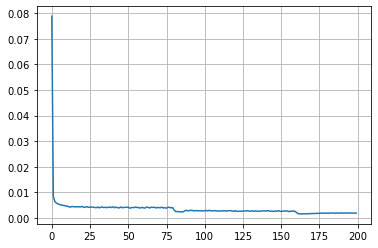

In [101]:
plt.plot(value_list)
plt.grid()
plt.show()

In [56]:
%tensorboard --logdir="/home/jupyter/mnist/WRN28-10-M3/summaries/events.out.tfevents.1637180574.deeplearning-1-vm.20453.0.v2"


In [3]:
um.ExpectedCalibrationError(num_bins=10)

2021-11-17 16:13:17.247982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 16:13:17.292235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 16:13:17.293031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 16:13:17.294648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [2]:

dataset_builder_class = ub.datasets.MnistDataset
train_dataset_builder = dataset_builder_class(
    split=tfds.Split.TRAIN)
    #use_bfloat16=FLAGS.use_bfloat16)
train_dataset = train_dataset_builder.load(batch_size=4)


Traceback (most recent call last):
  File "/opt/conda/envs/DAL/lib/python3.7/site-packages/uncertainty_baselines/datasets/datasets.py", line 54, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/opt/conda/envs/DAL/lib/python3.7/site-packages/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 'seqio'
Traceback (most recent call last):
  File "/opt/conda/envs/DAL/lib/python3.7/site-packages/uncertainty_baselines/datasets/__init__.py", line 63, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/opt/conda/envs/DAL/lib/python3.7/site-packages/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 'seqio'
2021-11-12 10:45:51.717784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] succ

In [3]:
a= iter(train_dataset)

2021-11-12 10:46:05.524676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
load_c_dataset = utils.load_mnist_c
corruption_types, max_intensity = utils.load_corrupted_test_info(
            "mnist")
corruption_types, max_intensity

(['identity',
  'shot_noise',
  'impulse_noise',
  'glass_blur',
  'motion_blur',
  'shear',
  'scale',
  'rotate',
  'brightness',
  'translate',
  'stripe',
  'fog',
  'spatter',
  'dotted_line',
  'zigzag',
  'canny_edges'],
 1)

In [19]:
for corruption in corruption_types:
            for intensity in range(1, max_intensity + 1):
                print((corruption,intensity))
                dataset = load_c_dataset(
                    corruption_name=corruption,
                    corruption_intensity=intensity,
                    batch_size=20,
                    use_bfloat16=True)

                test_datasets['{0}_{1}'.format(corruption, intensity)] = (
                    strategy.experimental_distribute_dataset(dataset))
dataset
                

('identity', 1)
('shot_noise', 1)


2021-11-12 10:51:01.054166: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:01.272305: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('impulse_noise', 1)


2021-11-12 10:51:01.479663: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('glass_blur', 1)


2021-11-12 10:51:01.691887: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:01.790068: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:01.881016: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('motion_blur', 1)
('shear', 1)
('scale', 1)


2021-11-12 10:51:01.984409: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.080198: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.179152: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('rotate', 1)
('brightness', 1)
('translate', 1)


2021-11-12 10:51:02.273010: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.359749: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.446436: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('stripe', 1)
('fog', 1)
('spatter', 1)


2021-11-12 10:51:02.541252: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.631279: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2021-11-12 10:51:02.714699: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


('dotted_line', 1)
('zigzag', 1)
('canny_edges', 1)


2021-11-12 10:51:02.809408: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.bfloat16, tf.bfloat16)>

In [20]:
datasets_to_evaluate = test_datasets

In [49]:
for dataset_name, test_dataset in datasets_to_evaluate.items():
        print((dataset_name, test_dataset))
        test_iterator = iter(test_dataset)
        images, labels = next(test_iterator).values()
        
        print((images).shape)
        c

('clean', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f18bc590>)


2021-11-12 10:58:33.767263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-11-12 10:58:33.769308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(10, 28, 28, 1)


NameError: name 'c' is not defined

In [29]:
listdatasets_to_evaluate.items()

dict_items([('clean', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f18bc590>), ('identity_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f024d5d0>), ('shot_noise_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f1405385490>), ('impulse_noise_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f042b750>), ('glass_blur_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f0409690>), ('motion_blur_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f02657d0>), ('shear_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f0281210>), ('scale_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f0223b90>), ('rotate_1', <tensorflow.python.distribute.input_lib.DistributedDataset object at 0x7f13f01ce5d0>), ('brightness_1', <tensorflow.python.distribute.input_lib.DistributedDat

In [7]:
    clean_test_dataset_builder = dataset_builder_class(
    split=tfds.Split.TEST)
    #use_bfloat16=FLAGS.use_bfloat16)
clean_test_dataset = clean_test_dataset_builder.load(
    batch_size=10)
    
    strategy = tf.distribute.MirroredStrategy()
    test_datasets = {
        'clean': strategy.experimental_distribute_dataset(clean_test_dataset),
    }

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2021-11-12 10:46:23.063140: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "RangeDataset/_3"
op: "RangeDataset"
input: "Const/_0"
input: "Const/_1"
input: "Const/_2"
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}



In [9]:
a=iter(dataset)

2021-11-11 17:48:25.764961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [16]:
x,y=next(a)
y

<tf.Tensor: shape=(20,), dtype=bfloat16, numpy=
array([6, 0, 7, 7, 8, 4, 8, 8, 1, 8, 0, 2, 9, 1, 0, 3, 9, 7, 0, 4],
      dtype=bfloat16)>